In [1]:
# numerics
import numpy as np
import math as m
import scipy
from scipy.fftpack import fft,ifft,fftshift,fft2
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
from scipy import signal
pi = m.pi

# plot
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.gridspec import GridSpec
from matplotlib.patches import FancyArrowPatch, ArrowStyle
import matplotlib.patches as patches
from wav_analysis.add_cb import add_color_bar_V
from cmap import purula

# others
import os
import happi
import h5py

plt.style.use("paper")

In [2]:
filename = '20ns'

# basic parameters
me = 1.
e = 1.
mp = 100 * me
c = 1
# -> wpe = 1

wpp = 1./np.sqrt(mp)  # proton plasma frequency
v_ratio = 15.         # c/vA
wcp = wpp/v_ratio     # cyclotron frequency
B0 = wcp*mp/e         # magnetic field magnitude

vA = c/v_ratio        # proton Afven speed
vbth = 0.03*vA        # background proton thermal velocity
vsth = 0.45*vA        # shell dist. proton thermal velocity
dt = 0.001            # simualtion time step, in wcp^-1

#使用初始背景磁场的大小来初步验证模拟结果
init_Bx = B0                     # B0 is on x axis
lambda_p = c/wpp             # characteristc length (proton inertial length)

# simulation length & grid 
Lx = 102.4*lambda_p         
Ly = 12.8*lambda_p
Nx = 512
Ny = 128
dx = Lx/Nx
dy = Ly/Ny

#setting grid
#空间上的单位是lambda_i
dx_norm = dx/lambda_p
dy_norm = dy/lambda_p
x = np.linspace(0,Nx,Nx+1)
y = np.linspace(0,Ny,Ny+1)

X,Y = np.meshgrid(x.astype(int),y.astype(int))


# integrate 
init_UB = 0.5 * init_Bx**2 * dx * dy * (Nx+1) * (Ny+2)

In [3]:
with h5py.File('./data/' + filename + '_field0.h5', 'r') as f:
    # 列出所有 dataset
    print(list(f.keys()))
    field0_t = f['field0_t'][:]
    Bx = f['Bx'][:]
    By = f['By'][:]
    Bz = f['Bz'][:]
    # Ex = f['Ex'][:]
    # Ey = f['Ey'][:]
    # Ez = f['Ez'][:]

['Bx', 'By', 'Bz', 'Ex', 'Ey', 'Ez', 'field0_t']


In [4]:
every = 50
# wave frequency
t_start = 100
t_end = 450

n_start = int(t_start/dt/every) 
n_end = int(t_end/dt/every)

t_select = field0_t[n_start:n_end]*wcp
bx = (Bx[n_start:n_end,:,:]-B0)/B0
by = By[n_start:n_end,:,:]/B0
bz = Bz[n_start:n_end,:,:]/B0

bx -= np.mean(bx, axis=(1,2), keepdims=True)
by -= np.mean(by, axis=(1,2), keepdims=True)
bz -= np.mean(bz, axis=(1,2), keepdims=True)

# Number of sample points
N = len(t_select)
#sample spacing
DT = t_select[1] - t_select[0]
fs = 1/DT
freq = fftfreq(N, DT)[:N//2]*2*np.pi

bx_f = fft(bx, axis=0)
bx_f_avg = np.mean(np.abs(bx_f)**2, axis=(1,2))
xpsd = (2 / (N * fs)) * bx_f_avg[:N//2]

by_f = fft(by, axis=0)
by_f_avg = np.mean(np.abs(by_f)**2, axis=(1,2))
ypsd = (2 / (N * fs)) * by_f_avg[:N//2]

bz_f = fft(bz, axis=0)
bz_f_avg = np.mean(np.abs(bz_f)**2, axis=(1,2))
zpsd = (2 / (N * fs)) * bz_f_avg[:N//2]

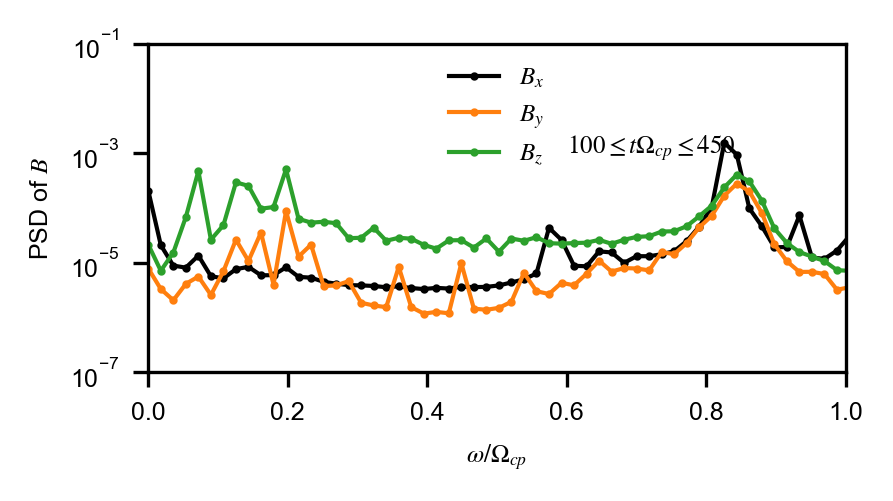

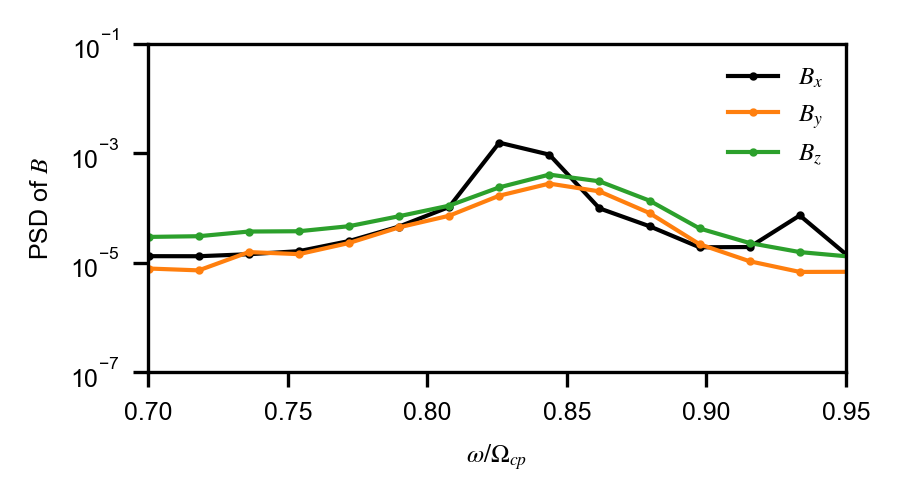

In [6]:
scale = 100

plt.close()
fig,ax = plt.subplots(figsize=[3, 1.5])
ax.set_yscale('log')
ax.plot(freq, xpsd, 'o-', c='black',  label='$B_x$', ms=1)
ax.plot(freq, ypsd, 'o-', c='C1',  label='$B_y$', ms=1)
ax.plot(freq, zpsd, 'o-', c='C2',  label='$B_z$', ms=1)
ax.set_xlim(0,1)
ax.set_ylim(1e-7, 1e-1)
ax.set_xlabel('$\omega/\Omega_{cp}$')
ax.set_ylabel('PSD of $B$')
ax.text(0.6,1e-3,'$100 \leq t\Omega_{cp} \leq 450$')
ax.legend()
plt.show()

plt.close()
fig,ax = plt.subplots(figsize=[3, 1.5])
ax.set_yscale('log')
ax.plot(freq, xpsd, 'o-', c='black',  label='$B_x$', ms=1)
ax.plot(freq, ypsd, 'o-', c='C1',  label='$B_y$', ms=1)
ax.plot(freq, zpsd, 'o-', c='C2',  label='$B_z$', ms=1)
ax.set_xlim(0.7,0.95)
ax.set_ylim(1e-7, 1e-1)
ax.set_xlabel('$\omega/\Omega_{cp}$')
ax.set_ylabel('PSD of $B$')
# ax.text(0.85,1e-3,'$100 \leq t\Omega_{cp} \leq 400$')
ax.legend()
plt.show()

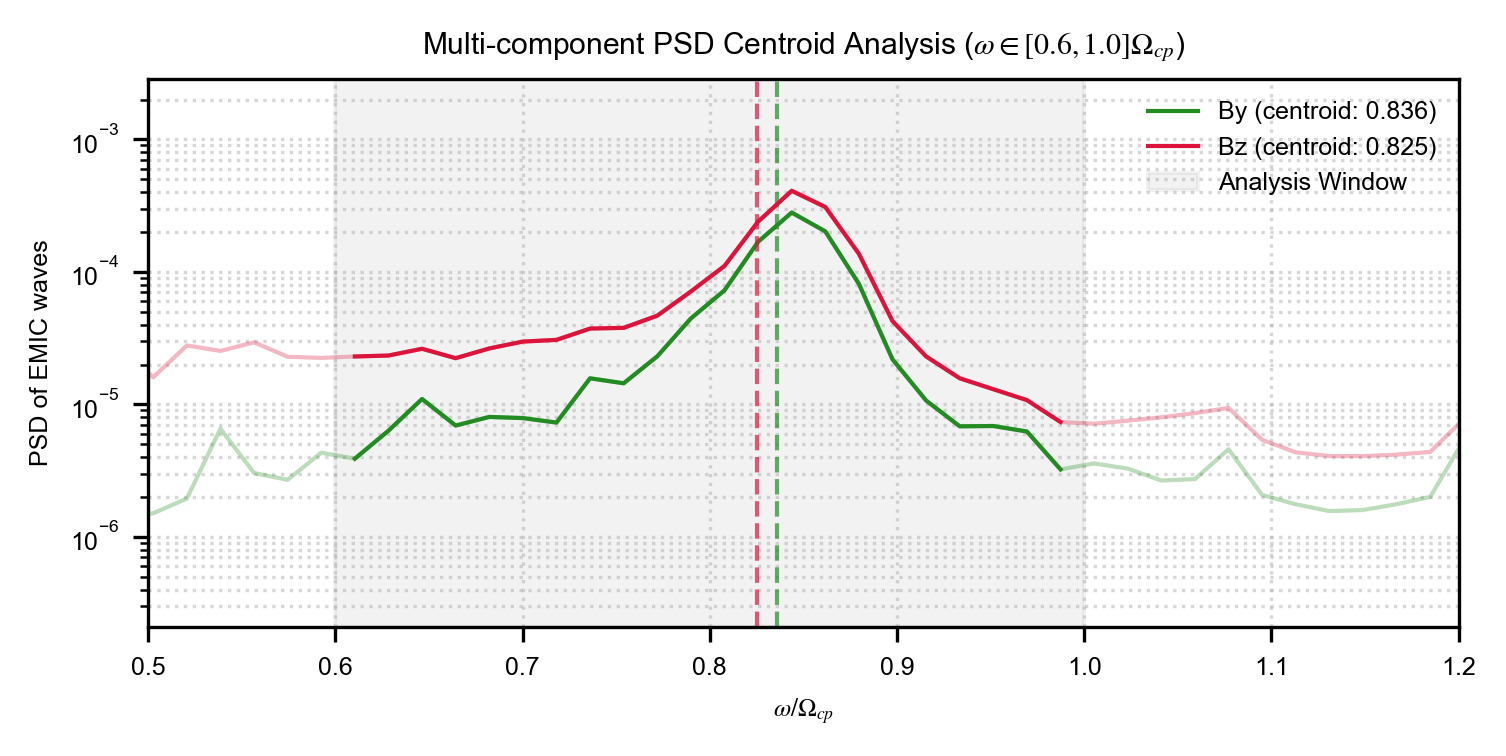

In [18]:
def get_centroid(f, psd, f_range):
    """
    计算指定频率区间内的能量重心
    """
    mask = (f >= f_range[0]) & (f <= f_range[1])
    f_local = f[mask]
    p_local = psd[mask]
    
    if len(p_local) == 0 or np.sum(p_local) == 0:
        return np.nan
    
    # 基线扣除：只计算高出背景噪声的部分
    p_pure = p_local - np.min(p_local)
    
    # 能量加权平均核心公式
    centroid = np.sum(f_local * p_pure) / np.sum(p_pure)
    return centroid

# 1. 设置分析区间 (根据你的修改: 0.6 - 1.0)
f_min, f_max = 0.6, 1.0
target_range = (f_min, f_max)

# 2. 计算各分量重心
centroid_y = get_centroid(freq, ypsd, target_range)
centroid_z = get_centroid(freq, zpsd, target_range)

# 3. 使用面向对象风格绘图
fig, ax = plt.subplots(figsize=(5, 2.5))

# 绘图配置
components = [
    ('By', ypsd, 'forestgreen', centroid_y),
    ('Bz', zpsd, 'crimson', centroid_z)
]

for label, psd, color, c_val in components:
    # 画全频谱 (ax.plot 替代 plt.plot)
    ax.plot(freq, psd, color=color, alpha=0.3)
    
    # 画分析区间（深色突出）
    mask = (freq >= f_min) & (freq <= f_max)
    ax.plot(freq[mask], psd[mask], color=color, 
            label=f'{label} (centroid: {c_val:.3f})')
    
    # 绘制重心虚线
    if not np.isnan(c_val):
        ax.axvline(c_val, color=color, linestyle='--', alpha=0.7)

# 4. 图表修饰 (使用 ax.set_... 方法)
ax.set_yscale('log')
ax.set_title(f'Multi-component PSD Centroid Analysis ($\omega \in [{f_min}, {f_max}] \Omega_{{cp}}$)')
ax.set_xlabel(r'$\omega / \Omega_{cp}$')
ax.set_ylabel('PSD of EMIC waves')

# 高亮分析窗口
ax.axvspan(f_min, f_max, color='gray', alpha=0.1, label='Analysis Window')

# 限制显示范围
ax.set_xlim(0.5, 1.2)
ax.grid(True, which='both', linestyle=':', alpha=0.5)
ax.legend()

fig.tight_layout()
plt.savefig("./picture/freq_EMIC.pdf", dpi=400, bbox_inches='tight')
plt.show()